# Spice Simulation of Sapflow Heater Control Circuit

Let's try to get it right before we get a PCB fabricated and loaded...

Spice simulation is standard electrical engineering stuff, see https://en.wikipedia.org/wiki/SPICE

We will do DC analysis and transient analysis to confirm this circuit has a chance of working.

## Requirements
In addition to Anaconda Python (https://www.continuum.io/anaconda) we need:
* the spice engine **ngspice** http://ngspice.sourceforge.net/
* Kicad http://kicad-pcb.org/ (or at least the hc.cir netlist we generate from the schematic we built in Kicad)


To build ngspice you need to enable xspice with the following:
`
cd release
../configure --with-x --with-readline=yes --disable-debug --enable-xspice
make
sudo make install
`
Note that there's a Python interface to the engine, **ngspyce** (https://github.com/ignamv/ngspyce), but I had difficulty getting the library it spoke with to run the xspice extensions.  So I gave up and just run ngspice from the command line.  It does the job.



In [254]:
# My standard setup for any Jupyter notebook
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 10)

%reload_ext autoreload
%autoreload 2

In [255]:
# Most of the heavy lifting is done in our fix.py module 
import fix

# Load in our netlist from Kicad
ksf = fix.KicadSpiceFix('../hc.cir')

# Specify the include files we need for our simulation.  
# These are used for component models.
ksf.set_lines('include', [
    '.INCLUDE bc337.model',
    '.INCLUDE CMPT3906.LIB',
    '.INCLUDE diodes.lib',
    '.INCLUDE LM358.101',
    '.INCLUDE tl431.lib',
    '.INCLUDE irfb7546pbf.spi'])


def set_target(ksf, target_v):
    """Adjust the pot for a given load voltage.
    
    We aim for target_v volts across our load terminals.
    Adjust the position of the potentiometer RV1 wiper to achieve this.
    
    The position is calculated by the gain of the diff stage 
    """
    # The gain of the voltage measuring stage is given by the ratio of its 
    # resistor pairs.
    diff_stage_gain = 33 / 100
    
    # The target value for the diff stage output is the target load voltage
    # scaled by the gain.
    target_v_diff = target_v * diff_stage_gain
    
    # The range of the pot output is 0V to 5V
    v_ref_max = 5
    
    # What percentage of the maximum reference voltage do we want?
    pos = target_v_diff / v_ref_max
    
    # Check it and set it.
    if pos < 0.0 or pos > 1.0:
        raise Exception("bad pot pos", pos, target_v)
    ksf.device('RV1').adjust(pos)
    

## DC (steady state) Analysis

Fix check that when the output is enabled, we provide the correct voltage to the load.

We will do a basic check for a $10\Omega$ load where we have dialed in a $10V$ load voltage.  (In which case we expect $I_{load} = 1A$ and $P_{load} = 10W$

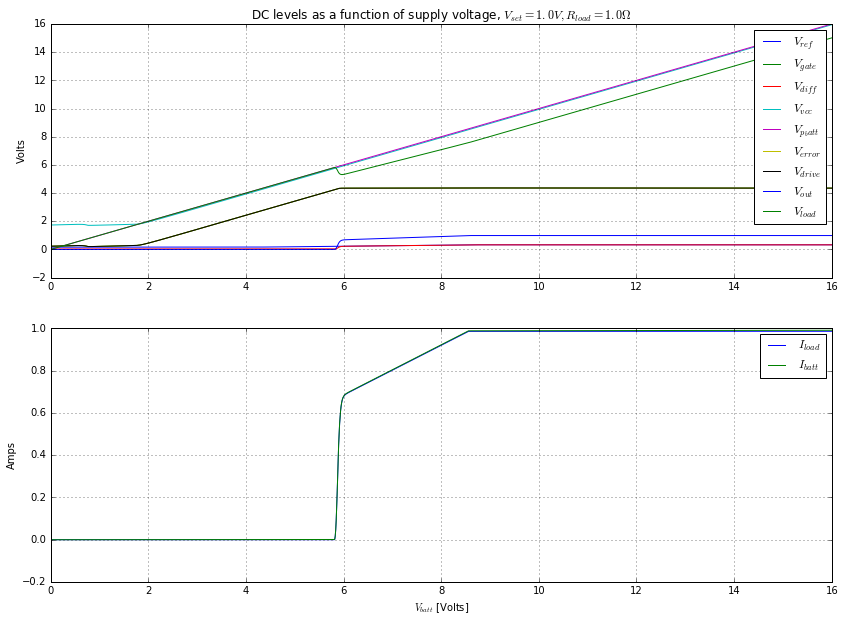

In [261]:
fix.delete_all_data_files()

node_str = "vcc p_batt gate diff load ref drive error i(vbatt) i(vload)"

Rload = 1.0
target_v = 1.0

set_target(ksf, target_v)

ksf.set_lines('load', [
    'Rload p_batt l1 {}R'.format(Rload),
    'Lload l1 l2 3uH',
    'Vload l2 LOAD 0V',
    ])

ksf.set_lines('supplies', [
    'Vbatt p_batt GND 13.2V',
    'Dwake p_batt enable 1N4148'])

ksf.set_lines('control', [
    '.control',
    'alter R5 1MegR',    
    'dc Vbatt 0 16 0.01',
    'wrdata out1 ' + node_str,
    '.endc'])
 
ksf.write_and_run('t1.cir')

Vc, V, I = fix.read_wrdata_file('out1.data', node_str) 

I['batt'] = -I["batt"]
V['out'] = V["p_batt"] - V['load']

title = "DC levels as a function of supply voltage, $V_{set}="+str(target_v)+"V, R_{load}="+str(Rload)+"\Omega$"
fix.plot_all(
    Vc, V, I,
    title=title,
    xlabel="$V_{batt}$ [Volts]")


In [225]:
for x in V.keys():
    print("{:10} {:10f} {:10f}".format(x, V[x][0], V[x][-1]))

print()    
for x in I.keys():
    print("{:10} {:10f} {:10f}".format(x, I[x][0], I[x][-1]))  

ref          1.947133   3.952958
gate         0.610898   4.712774
diff         0.034393   3.951499
vcc          1.698953  15.946650
p_batt       0.000000  16.000000
error        0.194403   4.119942
drive        0.205284   4.232281
out         -0.000000  11.973303
load         0.000000   4.026697

load        -0.000000  11.973300
batt        -0.000027  11.989170


As expected, above battery voltages of 10V the circuit acts as a linear regulator, holding the load voltage at 10V.  There's 6mV of variation over the range of conceivable battery voltages.

ref          1.623599   3.293884
gate         0.707129   4.672978
diff         0.034557   3.285811
vcc          1.795193  13.146220
p_batt      13.200000  13.200000
error        0.290633   4.116799
drive        0.301514   4.201531
out          0.000100   9.956254
load        13.199900   3.243746

wake         0.000000  -0.000044
load         0.000099   9.956254
dis          0.000000   0.000000
batt         0.000198   9.969109


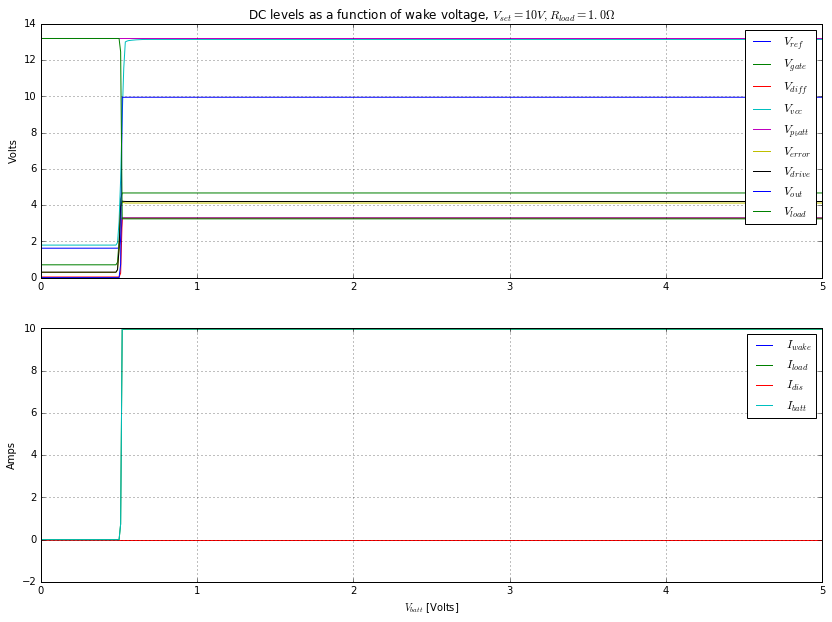

In [228]:
fix.delete_all_data_files()
node_str = "vcc p_batt gate diff load ref drive error i(vbatt) i(vload) i(vwake) i(vdis)"

Rload = 1.0
target_v = 10
set_target(ksf, target_v)

ksf.set_lines('load', [
    'Rload p_batt l1 {}R'.format(Rload),
    'Lload l1 l2 3uH',
    'Vload l2 LOAD 0V',
    ])

ksf.set_lines('supplies', [
    'Vbatt p_batt GND 13.2V',
    'Vwake wake GND 0V', 
    'Vdis disable GND 0V'])

ksf.set_lines('control', [
    '.control',
    'dc Vwake 0 5 0.01',
    'wrdata out2 ' + node_str,
    '.endc'])
 
ksf.write_and_run('t2.cir')

Vc, V, I = fix.read_wrdata_file('out2.data', node_str) 

I['batt'] = -I["batt"]
V['out'] = V["p_batt"] - V['load']

title = "DC levels as a function of wake voltage, $V_{set}="+str(target_v)+"V, R_{load}="+str(Rload)+"\Omega$"
fix.plot_all(
    Vc, V, I,
    title=title,
    xlabel="$V_{batt}$ [Volts]")

for x in V.keys():
    print("{:10} {:10f} {:10f}".format(x, V[x][0], V[x][-1]))

print()    
for x in I.keys():
    print("{:10} {:10f} {:10f}".format(x, I[x][0], I[x][-1]))  
    

In [383]:
def wobbles(signal, threshold=1e-4):
    dsig = np.diff(signal)
    dsig = np.insert(dsig, 0, dsig[0])
    dsig = np.insert(dsig, -1, dsig[-1])
    peak_indices, = np.where((dsig[:-1] * dsig[1:]) < 0)
    delta_peaks = np.abs(np.insert(np.diff(signal[peak_indices]), -1, 0))
    return peak_indices[delta_peaks > threshold]


def transient_analysis(ksf, duration, supplies, target_v, Rload, action=None, show=True):
    """Wrap up code for studying a given transition.
    
    * *Duration* gives how long the analysis runs.  10% of the time precedes the event, 90% follows.
    * *Supplies* is a list of strings specifying lines for SPICE.
    * *action* is a string that is included in the plot title.
    """
    fix.delete_all_data_files()
    node_str = "vcc p_batt gate diff load ref drive error i(vbatt) i(vload)"

    set_target(ksf, target_v)

    ksf.set_lines('load', [
        'Rload p_batt l1 {}R'.format(Rload),
        'Lload l1 l2 3uH',
        'Vload l2 LOAD 0V',
        ])

    ksf.set_lines('control', [
        '.control',
        'alter R4 1mR',    
        'alter R5 1MegR',    
        'alter R14 1kR',
        'tran 1us {}ms'.format(duration),
        'wrdata out_tran ' + node_str,
        '.endc'])

    pre = duration/10
    
    ksf.set_lines('supplies', [line.format(pre=pre) for line in supplies])

    ksf.write_and_run('trans.cir')

    t, V, I = fix.read_wrdata_file('out_tran.data', node_str)

    # convert to milliseconds and shift so that event occurs at 0ms
    t = t * 1000 - pre

    I['batt'] = -I["batt"]
    V['out'] = V["p_batt"] - V['load']
    
    wob = wobbles(V['out'])

    if show:
        title = "Transient Analysis: " + action + ", $V_{set}="+str(target_v)+"V, R_{load}="+str(Rload)+"\Omega$"
        xlabel='Time [mS]'
        fix.plot_all(
            t, V, I,
            title=title,
            xlabel=xlabel)
        plt.subplot(2,1,1)
        plt.plot(t[wob], V['out'][wob], 'r.')

    return t, V['out'], wob




20


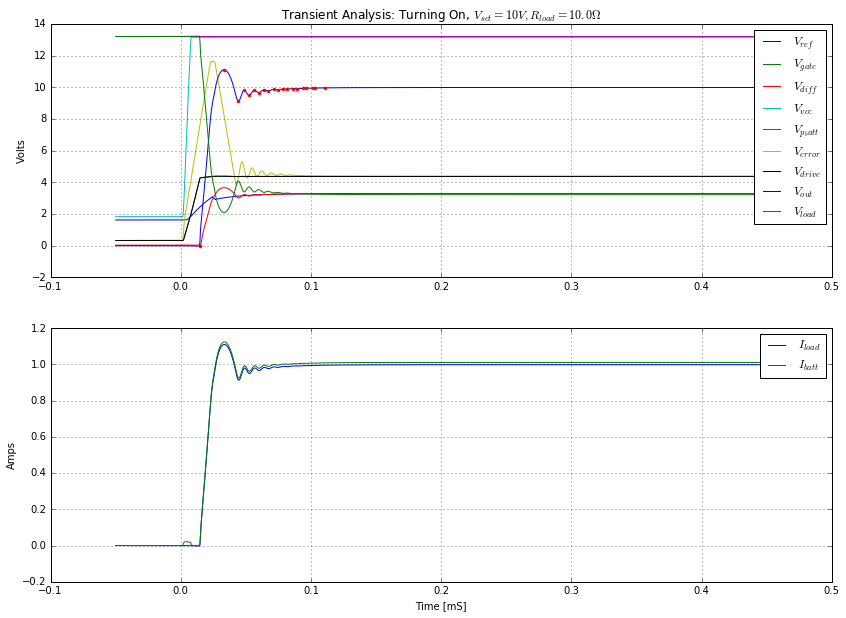

In [384]:
fix.delete_all_data_files()

Rload = 10.0
target_v = 10

supplies = [
    'Vbatt p_batt GND 13.2V',
    'Ven enable GND 0V PULSE(0V 5V {pre}ms 1ns)']


t, vout, wob = transient_analysis(
    ksf, duration=0.5, supplies=supplies, action="Turning On", Rload=Rload, target_v=target_v)
print(len(wob))

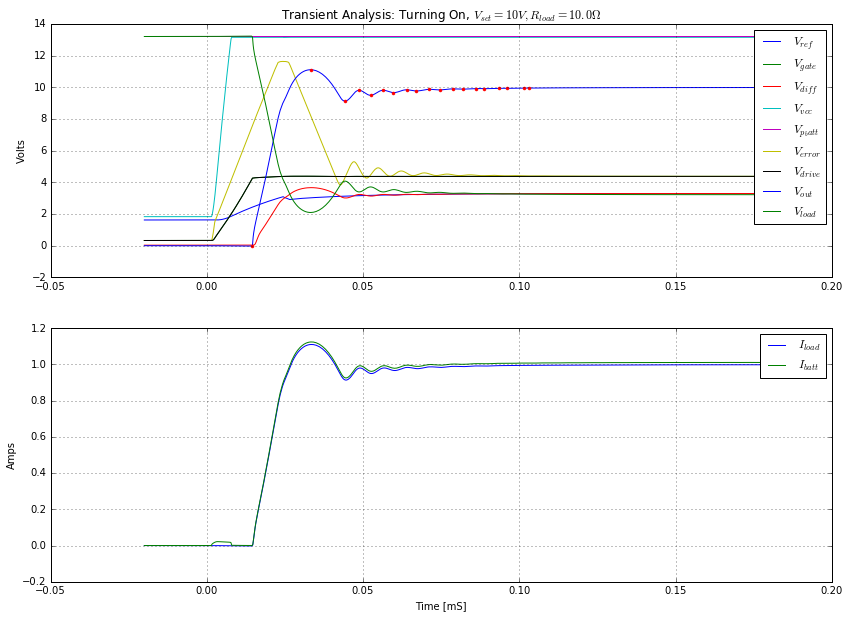

In [385]:
fix.delete_all_data_files()

Rload = 10.0
target_v = 10

supplies = [
    'Vbatt p_batt GND 13.2V',
    'Ven enable GND 0V PULSE(0V 5V {pre}ms 1ns)']

o = transient_analysis(ksf, duration=0.2, supplies=supplies, action="Turning On", Rload=Rload, target_v=target_v)


##########STDOUT##########

Circuit: * ../hc.cir

  unrecognized parameter (nk) - ignored
Reducing trtol to 1 for xspice 'A' devices
Doing analysis at TEMP = 27.000000 and TNOM = 27.000000


Initial Transient Solution
--------------------------

Node                                   Voltage
----                                   -------
drive                                  4.37374
n_c3_p2                                4.37374
xu2a.11                              0.0402298
xu2a.12                              0.0404144
xu2a.6                             0.000412899
xu2a.7                                 3.29403
diff                                   3.29406
xu2a.53                                11.0471
xu2a.54                                    0.6
xu2a.90                            -0.00054898
xu2a.91                                     40
xu2a.92                                    -40
vcc                                    13.1471
xu2a.99                                6.57355
xu

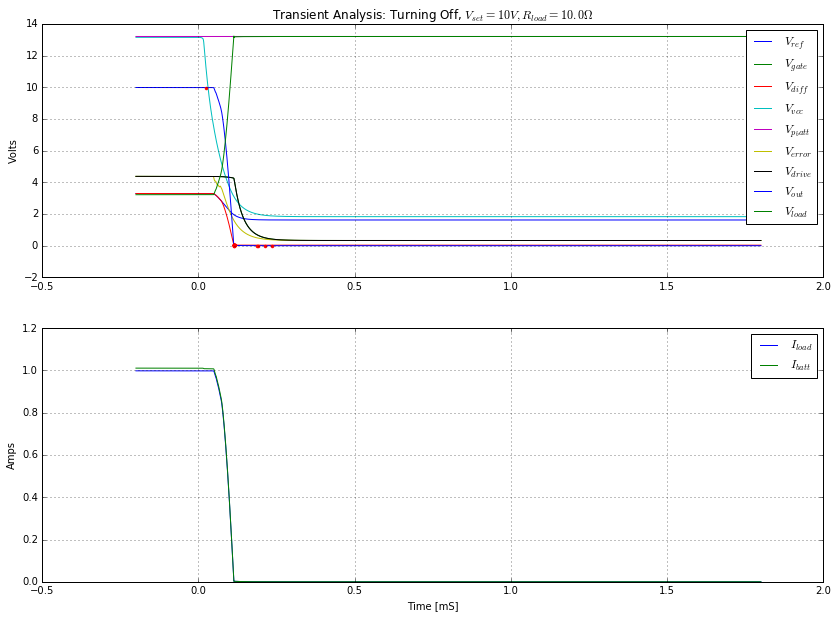

In [386]:
fix.delete_all_data_files()
Rload = 10.0
target_v = 10

supplies = [
    'Vbatt p_batt GND 13.2V',
    'Ven enable GND 0V PULSE(5V 0V {pre}ms 1ns)']


o = transient_analysis(ksf, duration=2, supplies=supplies, action="Turning Off", Rload=Rload, target_v=target_v)


##########STDOUT##########

Circuit: * ../hc.cir

  unrecognized parameter (nk) - ignored
Reducing trtol to 1 for xspice 'A' devices
Doing analysis at TEMP = 27.000000 and TNOM = 27.000000


Initial Transient Solution
--------------------------

Node                                   Voltage
----                                   -------
drive                                  4.37374
n_c3_p2                                4.37374
xu2a.11                              0.0402298
xu2a.12                              0.0404144
xu2a.6                             0.000412899
xu2a.7                                 3.29403
diff                                   3.29406
xu2a.53                                11.0471
xu2a.54                                    0.6
xu2a.90                            -0.00054898
xu2a.91                                     40
xu2a.92                                    -40
vcc                                    13.1471
xu2a.99                                6.57355
xu

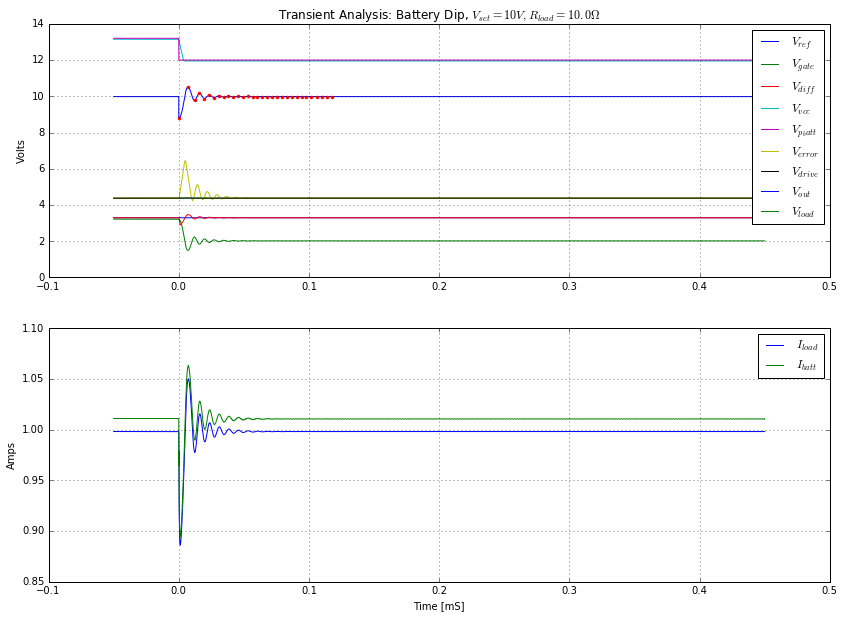

In [387]:
fix.delete_all_data_files()

Rload = 10.0
target_v = 10

supplies = [
    'Vbatt p_batt GND 13.2V PULSE(13.2V 12V {pre}ms 1ns)',
    'Rd drive gate 1mR',
    'Ven enable GND 5V']


o = transient_analysis(ksf, duration=0.5, supplies=supplies, action="Battery Dip", Rload=Rload, target_v=target_v)


0.0879396


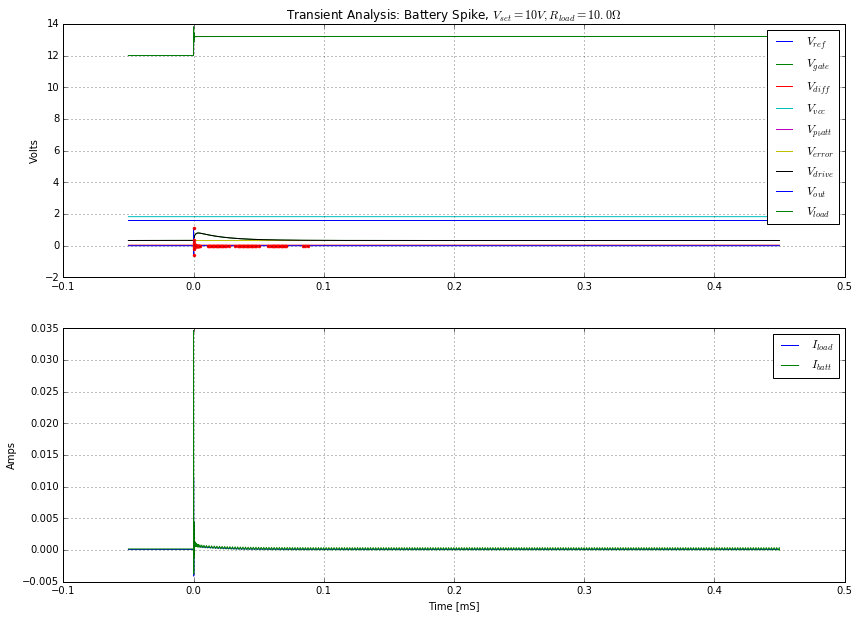

In [388]:
fix.delete_all_data_files()
Rload = 10.0
target_v = 10

supplies = [
    'Vbatt p_batt GND 13.2V PULSE(12V 13.2V {pre}ms 1ns)',
    'Rd drive gate 1mR',
    'Vwake wake GND 5V', 
    'Vdis disable GND 0V']


t, vout, wob = transient_analysis(ksf, duration=0.5, supplies=supplies, action="Battery Spike", Rload=Rload, target_v=target_v)
last = t[wob[-1]]
print(last)


In [391]:

supplies = [
    'Vbatt p_batt GND 13.2V',
    'Ven enable GND 0V PULSE(0V 5V {pre}ms 1ns)']


for target_v in np.arange(2, 14, 2):
    for Rload in np.arange(1, 10, 0.1):
        fix.delete_all_data_files()
        t, vout, wob = transient_analysis(
            ksf, duration=1, supplies=supplies, 
            Rload=Rload, target_v=target_v, show=False)
        last = t[wob[-1]]
        print(target_v, Rload, last, len(wob))
        

2 1.0 0.0283728 11
2 1.1 0.1243476 42
2 1.2 0.0283156 11
2 1.3 0.0283025 11
2 1.4 0.8956053 835
2 1.5 0.8922692 833
2 1.6 0.8991635 847
2 1.7 0.0758612 12
2 1.8 0.0283448 9
2 1.9 0.6889724 627
2 2.0 0.0283444 11
2 2.1 0.0283235 11
2 2.2 0.0283564 10
2 2.3 0.7568716 698
2 2.4 0.7458923 689
2 2.5 0.7869122 727
2 2.6 0.0284283 10
2 2.7 0.0284782 10
2 2.8 0.0285017 10
2 2.9 0.441685 379
2 3.0 0.5895404 529
2 3.1 0.7838448 726
2 3.2 0.1385987 64
2 3.3 0.0283502 9
2 3.4 0.0284029 9
2 3.5 0.088693 19
2 3.6 0.0283366 9
2 3.7 0.0285349 10
2 3.8 0.8997207 844
2 3.9 0.4614461 399
2 4.0 0.0285096 9
2 4.1 0.0856347 18
2 4.2 0.0283719 9
2 4.3 0.0283358 8
2 4.4 0.0285211 9
2 4.5 0.1513735 78
2 4.6 0.0285764 9
2 4.7 0.0285642 9
2 4.8 0.0284018 8
2 4.9 0.0790428 11
2 5.0 0.1484317 74
2 5.1 0.0283408 8
2 5.2 0.0284856 7
2 5.3 0.3375783 273
##########STDOUT##########

Circuit: * ../hc.cir

  unrecognized parameter (nk) - ignored
Reducing trtol to 1 for xspice 'A' devices
Doing analysis at TEMP = 27.00000

In [403]:
supplies = [
    'Vbatt p_batt GND 13.2V',
    'Ven enable GND 0V PULSE(0V 5V {pre}ms 1ns)']

target_v = 2
for Rload in np.arange(1, 5, 0.1):
    fix.delete_all_data_files()
    t, vout, wob = transient_analysis(
        ksf, duration=1, supplies=supplies, 
        Rload=Rload, target_v=target_v, show=False)
    last = t[wob[-1]]
    print(target_v, Rload, last, len(wob))

2 1.0 0.0283728 11
2 1.1 0.1243476 42
2 1.2 0.0283156 11
2 1.3 0.0283025 11
2 1.4 0.8956053 835
2 1.5 0.8922692 833
2 1.6 0.8991635 847
2 1.7 0.0758612 12
2 1.8 0.0283448 9
2 1.9 0.6889724 627
2 2.0 0.0283444 11
2 2.1 0.0283235 11
2 2.2 0.0283564 10
2 2.3 0.7568716 698
2 2.4 0.7458923 689
2 2.5 0.7869122 727
2 2.6 0.0284283 10
2 2.7 0.0284782 10
2 2.8 0.0285017 10
2 2.9 0.441685 379
2 3.0 0.5895404 529
2 3.1 0.7838448 726
2 3.2 0.1385987 64
2 3.3 0.0283502 9
2 3.4 0.0284029 9
2 3.5 0.088693 19
2 3.6 0.0283366 9
2 3.7 0.0285349 10
2 3.8 0.8997207 844
2 3.9 0.4614461 399
2 4.0 0.0285096 9
2 4.1 0.0856347 18
2 4.2 0.0283719 9
2 4.3 0.0283358 8
2 4.4 0.0285211 9
2 4.5 0.1513735 78
2 4.6 0.0285764 9
2 4.7 0.0285642 9
2 4.8 0.0284018 8
2 4.9 0.0790428 11


2 1.3 0.0283569 11
2 1.4 0.8994831 840
2 1.5 0.8922692 833
2 1.6 0.8991635 847
2 1.7 0.8997594 842
2 1.8 0.8993891 844


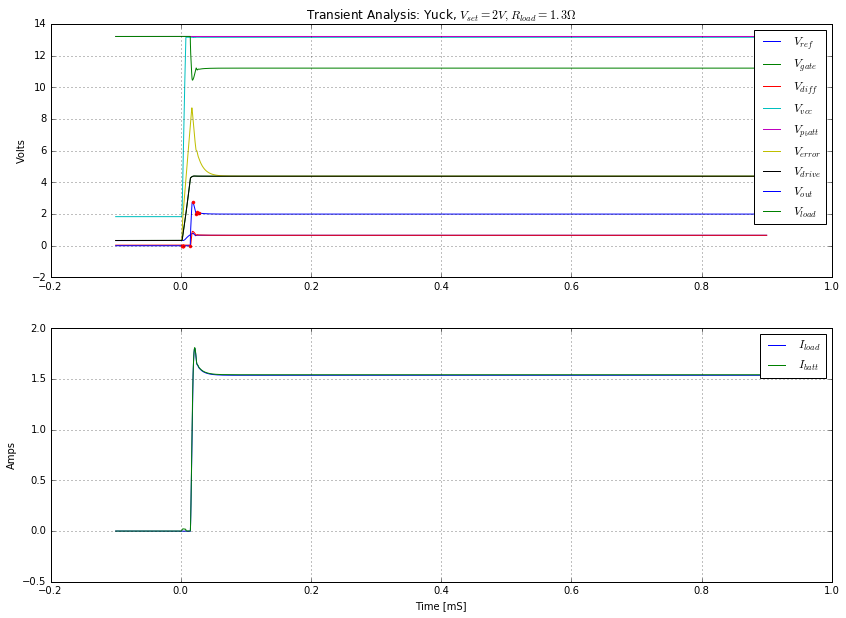

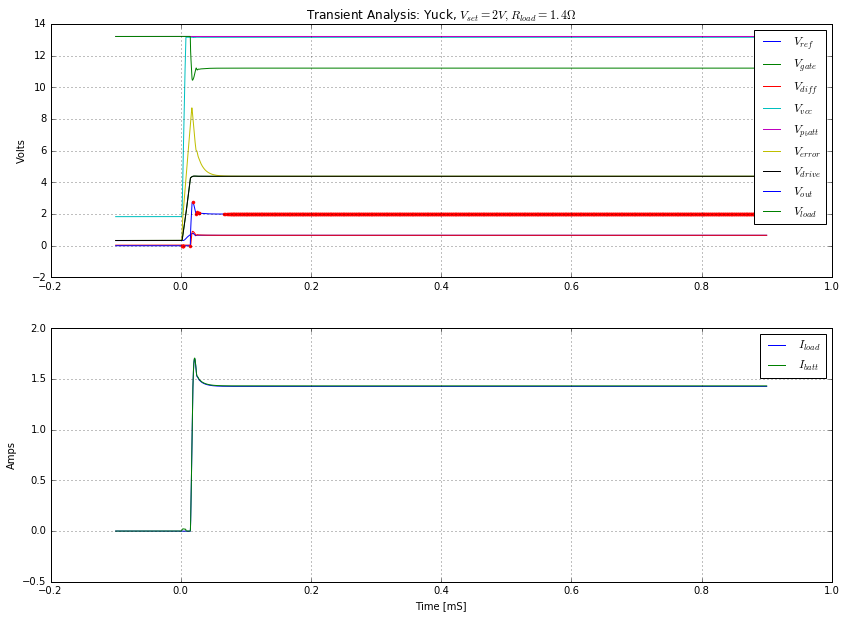

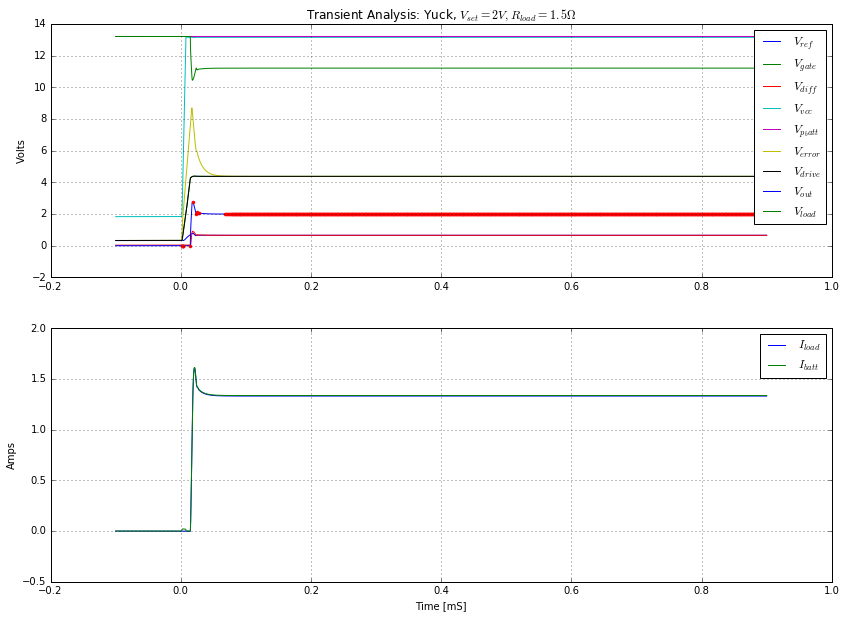

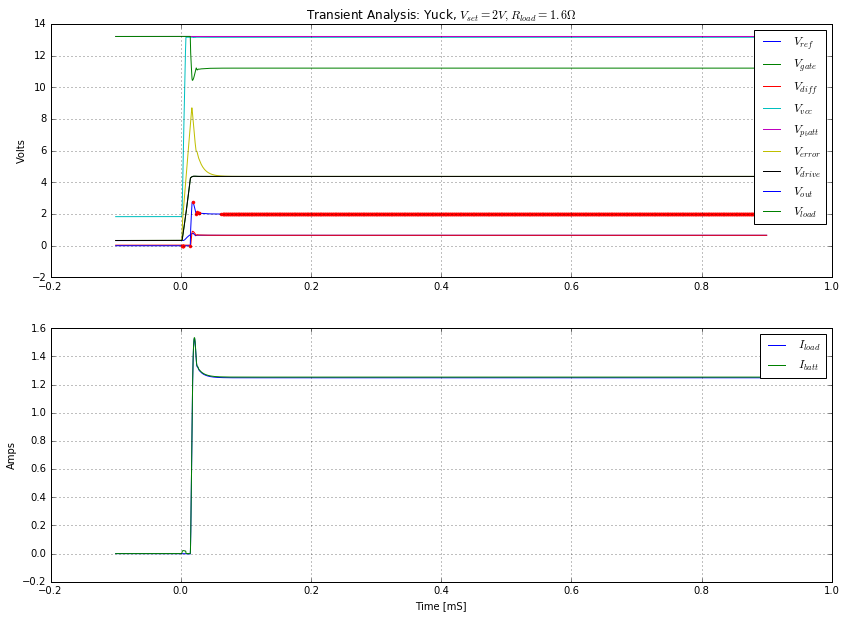

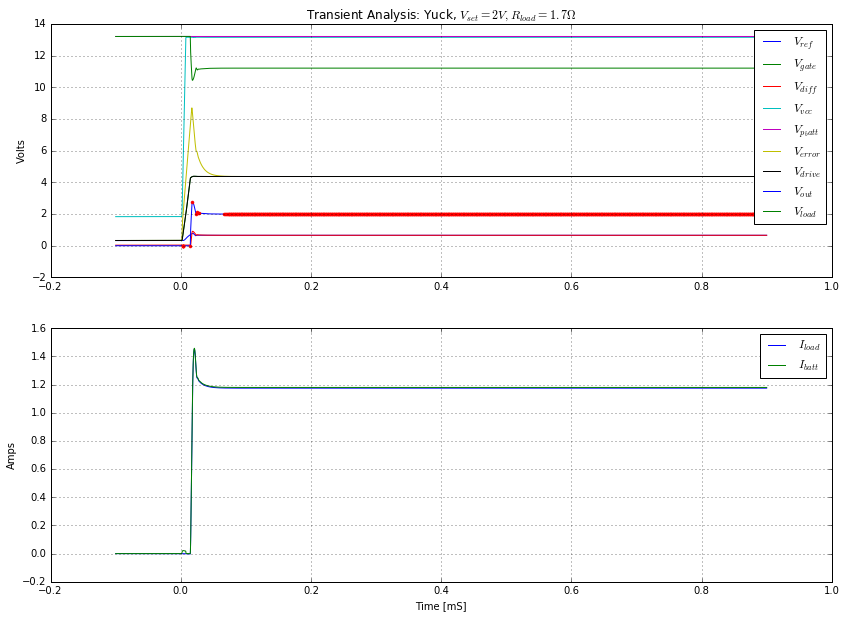

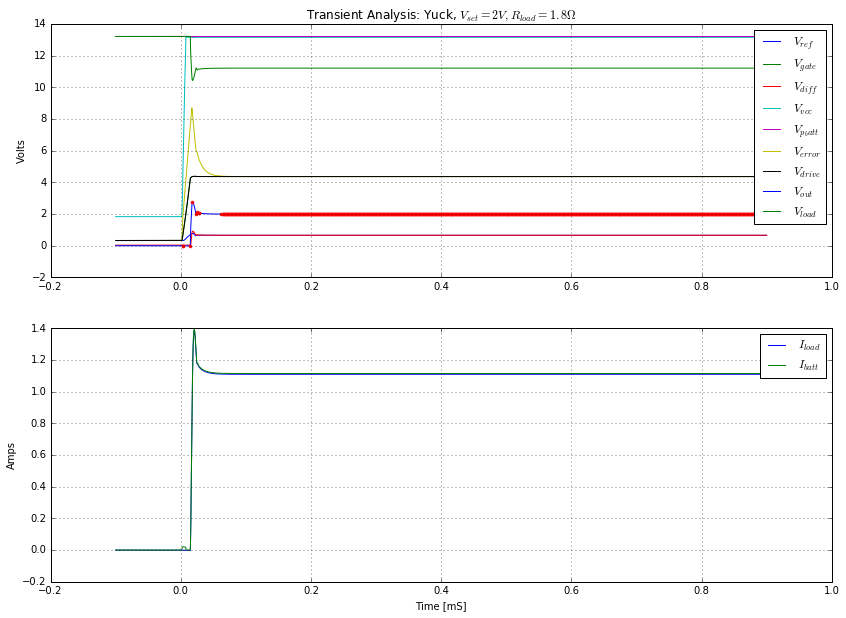

In [409]:
supplies = [
    'Vbatt p_batt GND 13.2V',
    'Ven enable GND 0V PULSE(0V 5V {pre}ms 1ns)']

target_v = 2
for Rload in np.arange(1.3, 1.9, 0.1):
    plt.figure()
    fix.delete_all_data_files()
    t, vout, wob = transient_analysis(
        ksf, duration=1, supplies=supplies, 
        Rload=Rload, target_v=target_v, show=True, action="Yuck")
    last = t[wob[-1]]
    print(target_v, Rload, last, len(wob))

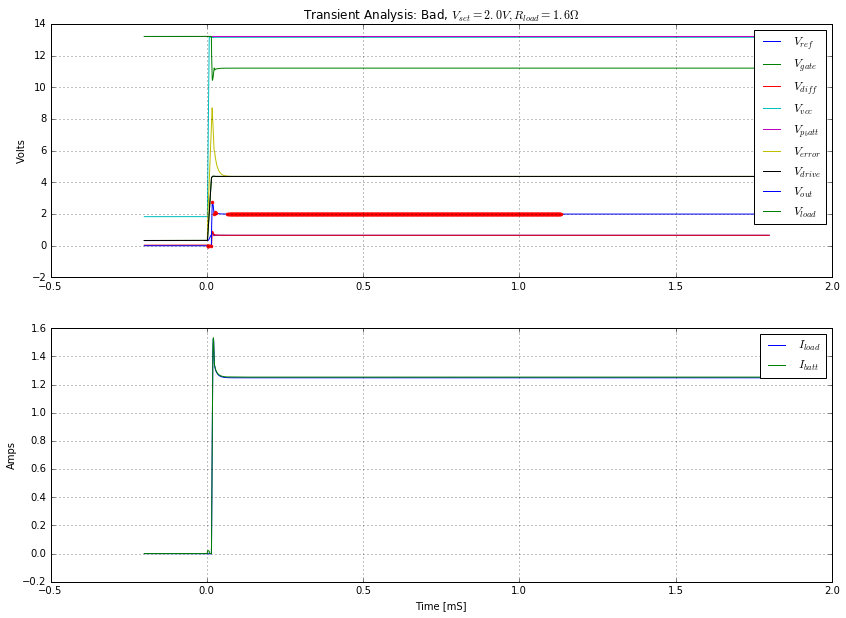

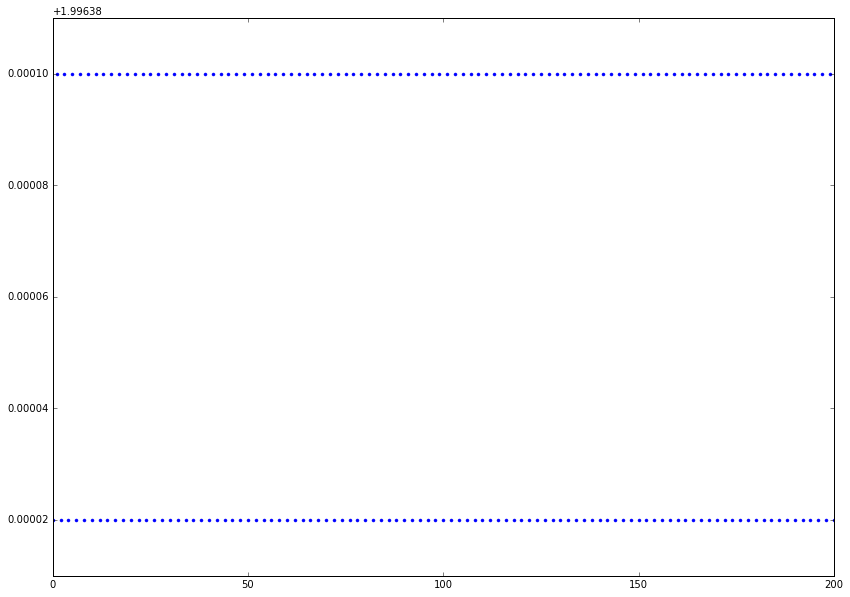

In [418]:
# 8 8.9 0.8993842 756

t, vout, wob = transient_analysis(
    ksf, duration=2, supplies=supplies, 
    Rload=1.6, target_v=2.0, action="Bad")
len(wob)
plt.figure()
plt.plot(vout[t>1.6], '.')

In [374]:
fix.delete_all_data_files()

Rload = 10.0
target_v = 10

supplies = [
    'Vbatt p_batt GND 13.2V',
    'Vwake wake GND 0V PULSE(5V 0V {pre}ms 1ns)', 
    'Vdis disable GND 0V']


transient_analysis(ksf, duration=2, supplies=supplies, action="Turning Off", Rload=Rload, target_v=target_v)

IndexError: index -1 is out of bounds for axis 0 with size 0

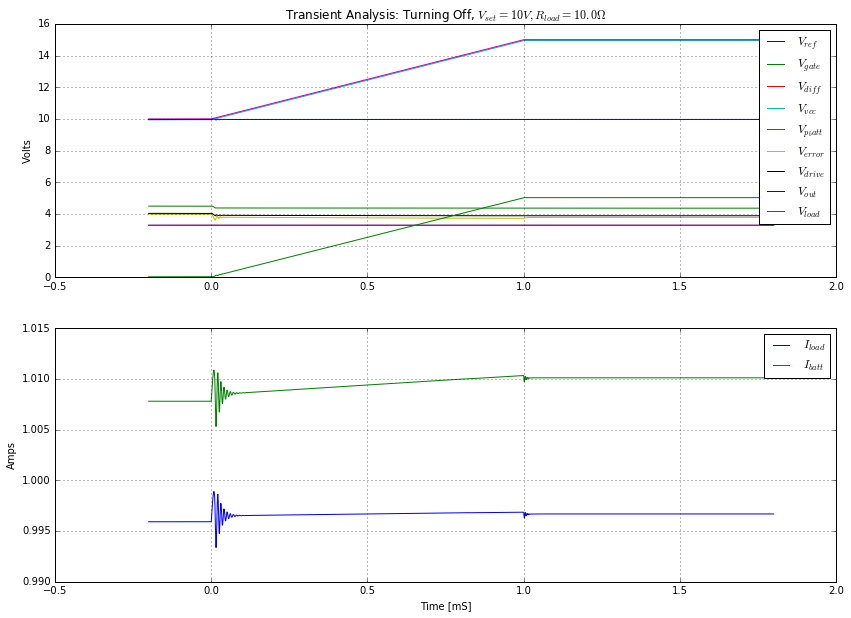

In [245]:
fix.delete_all_data_files()
node_str = "vcc p_batt gate diff load ref drive error i(vbatt) i(vload) i(vwake) i(vdis)"

Rload = 10.0
target_v = 10

supplies = [
    'Vbatt p_batt GND 13.2V PULSE(10V 15V {pre}ms 1ms',
    'Vwake wake GND 5V)', 
    'Vdis disable GND 0V']


transient_analysis(ksf, duration=2, supplies=supplies, action="Turning Off", Rload=Rload, target_v=target_v)

In [205]:
ksf.set_lines('control', [
    '.control',
    'tran Vwake 0 5 0.01',
    'wrdata out2 ' + node_str,
    '.endc'])
 
ksf.write_and_run('t2.cir')

Vc, V, I = fix.read_wrdata_file('out2.data', node_str) 

I['batt'] = -I["batt"]
V['out'] = V["p_batt"] - V['load']

title = "DC levels as a function of wake voltage, $V_{set}="+str(target_v)+"V, R_{load}="+str(Rload)+"\Omega$"
fix.plot_all(
    Vc, V, I,
    title=title,
    xlabel="$V_{batt}$ [Volts]")

for x in V.keys():
    print("{:10} {:10f} {:10f}".format(x, V[x][0], V[x][-1]))

print()    
for x in I.keys():
    print("{:10} {:10f} {:10f}".format(x, I[x][0], I[x][-1]))  
    

##########STDOUT##########

Circuit: * ../hc.cir

  unrecognized parameter (nk) - ignored

##########STDERR##########

TST0P is invalid, must be greater than zero.

 Error: unknown parameter on .tran - ignored

tran simulation(s) aborted
Error: no such function as i.
Note: No ".plot", ".print", or ".fourier" lines; no simulations run



FileNotFoundError: [Errno 2] No such file or directory: 'out2.data'

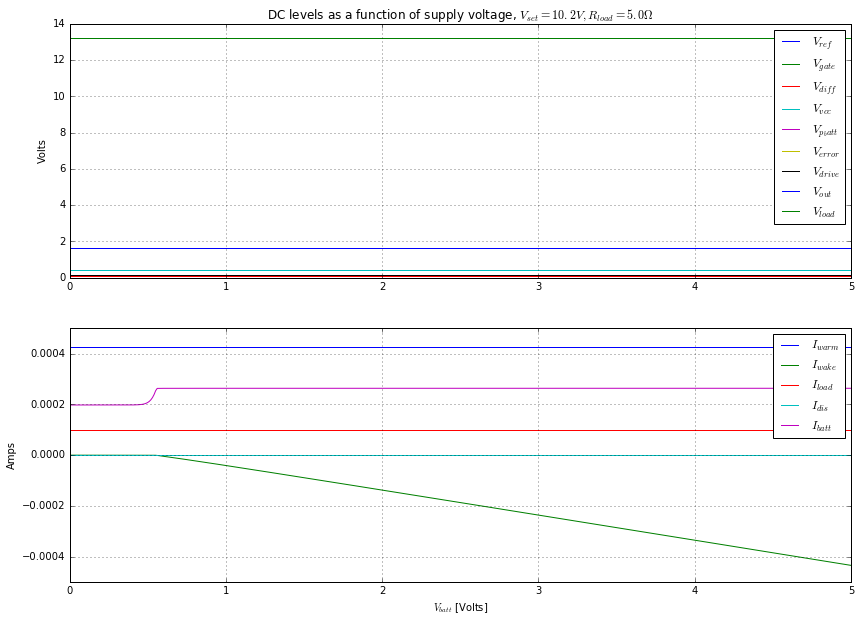

In [151]:
title = "DC levels as a function of supply voltage, $V_{set}="+str(target_v)+"V, R_{load}="+str(Rload)+"\Omega$"
fix.plot_all(
    Vc, V, I,
    title=title,
    xlabel="$V_{batt}$ [Volts]")

In [152]:
for x in V.keys():
    print("{:10} {:10f} {:10f}".format(x, V[x][0], V[x][-1]))

print()    
for x in I.keys():
    print("{:10} {:10f} {:10f}".format(x, I[x][0], I[x][-1]))  

ref          1.644392   1.644392
gate         0.404879   0.404879
diff         0.098735   0.098735
vcc          0.425004   0.425004
p_batt      13.200000  13.200000
error        0.122282   0.122282
drive        0.122515   0.122515
out          0.000490   0.000490
load        13.199510  13.199510

warm         0.000425   0.000425
wake         0.000000  -0.000434
load         0.000098   0.000098
dis          0.000000   0.000000
batt         0.000198   0.000264


In [150]:
Verror = {"error": V["out"] - 10}
fix.plot_all(
    Vc, Verror, None,
    from_to=(11, 16),
    title=title,
    xlabel="$V_{batt}$ [Volts]")


IndexError: index 0 is out of bounds for axis 0 with size 0

Now let's check that the enable circuitry works.

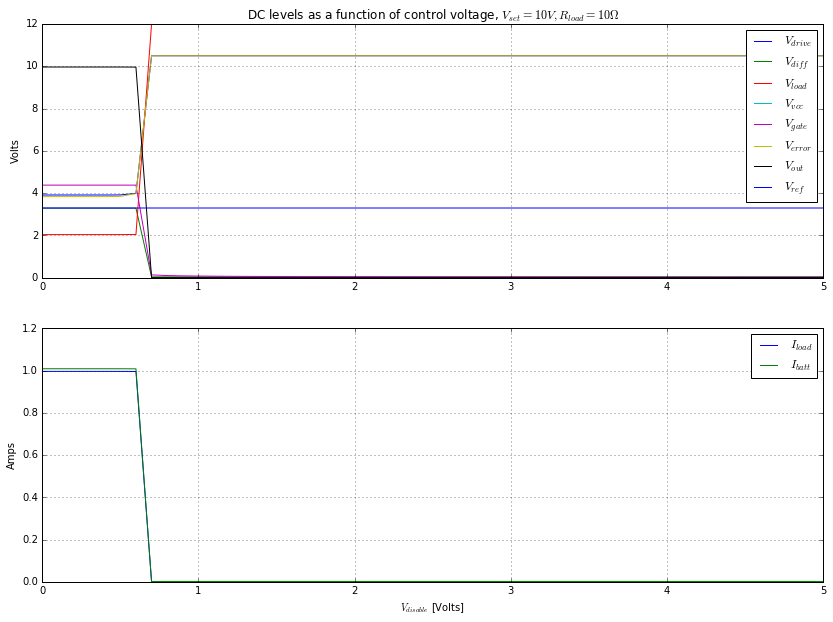

In [24]:
fix.delete_all_data_files()

node_str = "vcc gate diff load ref drive error i(vbatt) i(vload)"

Rload = 10
target_v = 10
set_target(target_v)

ksf.set_lines('control', [
    '.control',
    'dc Vdis 0 5 0.1',
    'wrdata out2 ' + node_str,
    '.endc'])

ksf.write_and_run('t2.cir')

Vc, V, I = fix.read_wrdata_file('out2.data', node_str)

V['out'] = V["vcc"] - V['load']
I['batt'] = -I["batt"]

title = "DC levels as a function of control voltage, $V_{set}="+str(target_v)+"V, R_{load}="+str(Rload)+"\Omega$"
fix.plot_all(
    Vc, V, I,
    title=title,
    xlabel="$V_{disable}$ [Volts]")
  

As hoped, the transition occurs between 0.3 and 1.0V, so that will work fine with 3V3, 5V and 12V control lines (meaning we can use Arduino and CR1000 loggers).

## Transient (time domain) Analysis

* How smoothly do we transition between on and off states?
* How do we respond to changes in battery voltage?


### Turning on the heater output

The battery is connected, the output is enabled by dropping the disable input's voltage from 5V to 0V (in 1ns).
The load has got $4{\mu}H$ of inductance, this is the sort of value we'd expect for 10m of cable running to a heater element (conductor diameter: 2mm, separation between them: 1mm).  See https://www.eeweb.com/toolbox/parallel-wire-inductance


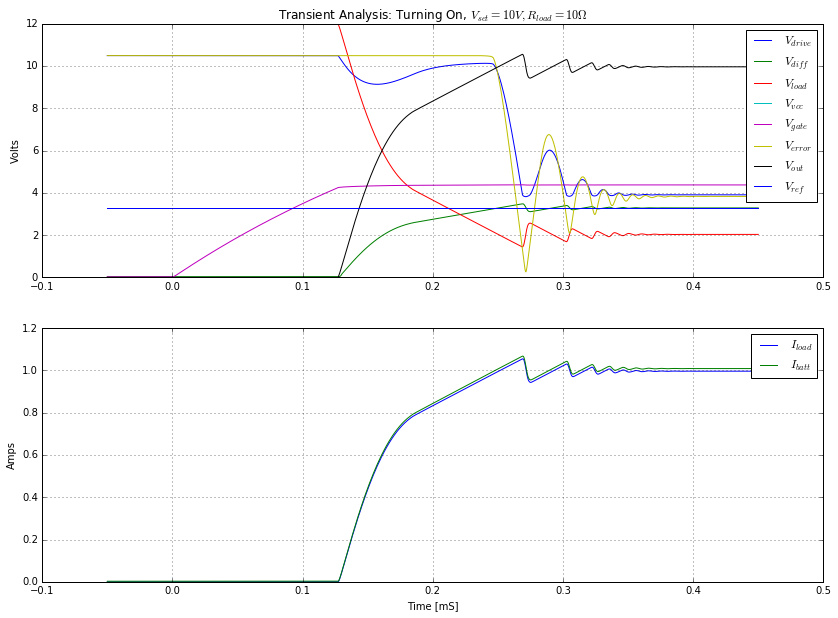

In [26]:
ksf.set_lines('load', [
    'Rload VCC l1 {}R'.format(Rload),
    'Lload l1 l2 4uH',
    'Vload l2 LOAD 0V',
    ])

supplies = [
    'Vbatt VCC GND 12V',
    'Vdis disable GND 0V PULSE(5V 0V {pre}ms 1ns)']
transient_analysis(duration=0.5, supplies=supplies, action="Turning On")

In this simulation the output voltage, $V_{out}$, transitions from 0V to 10V in $250{\mu}S$ and settles down in $400{\mu}S$  Damping the oscillations is a reasonably big design challenge.  

### Turning off the heater output

The circuit is providing current to the heater element.  We stop this by pulling the disable line high (taking 1ns to do it).


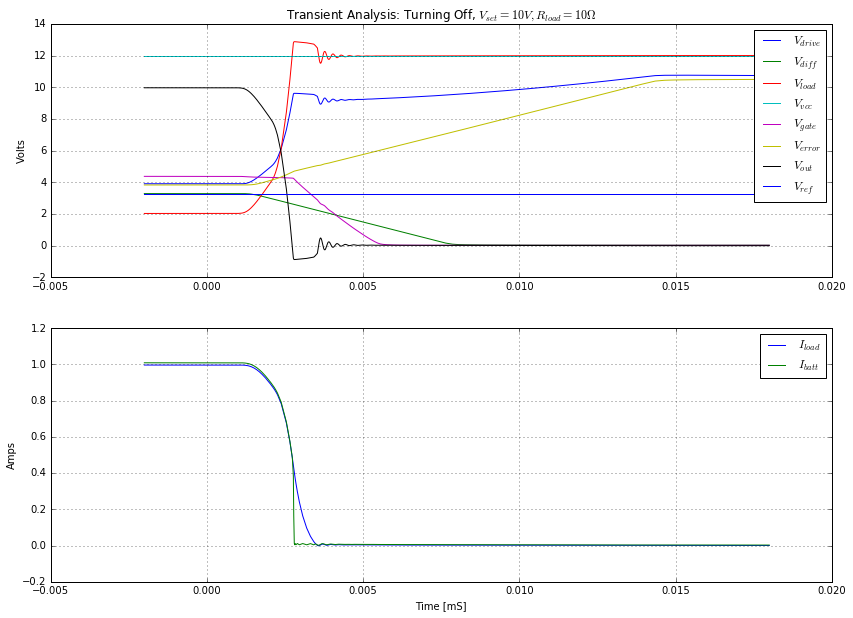

In [27]:
supplies = [
    'Vbatt VCC GND 12V',
    'Vdis disable GND 0V PULSE(0V 5V {pre}ms 1ns)']
transient_analysis(0.02, supplies, "Turning Off")

The current turns off nice and fast.  Note that the voltage across the load goes negative for about $1{\mu}S$ - this is due to the inductance in the cable to the heaters.  The protection diode, D1, clamps this back EMF at about 1V, stopping any damage to the circuit.

### Battery Voltage Rise

Here we simulate the 12V battery jumping by 1V in 1ms.  The output stays steady, betraying only a slight wobble (of 0.1%) as the rate of change switched from 0V/mS to 10V/ms and back again.

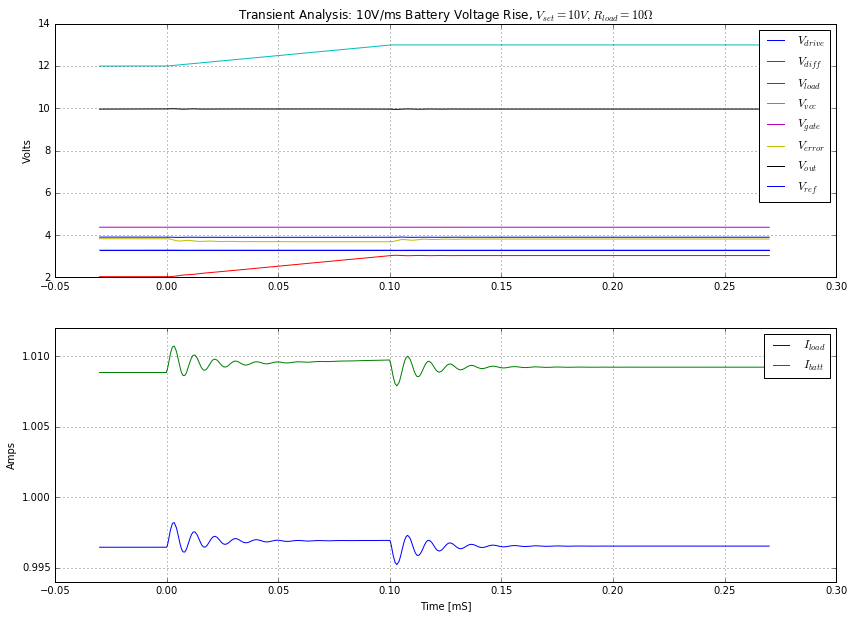

In [28]:
supplies = [
    'Vbatt VCC GND 12V  PULSE(12V 13V {pre}ms 100us)',
    'Vdis disable GND 0V']
transient_analysis(duration=0.3, supplies=supplies, action="10V/ms Battery Voltage Rise")

### Battery Voltage Fall

As before but we simulate a 1V fall over 1ms.  The impact is as before, wobbles at the start and end of the ramp.


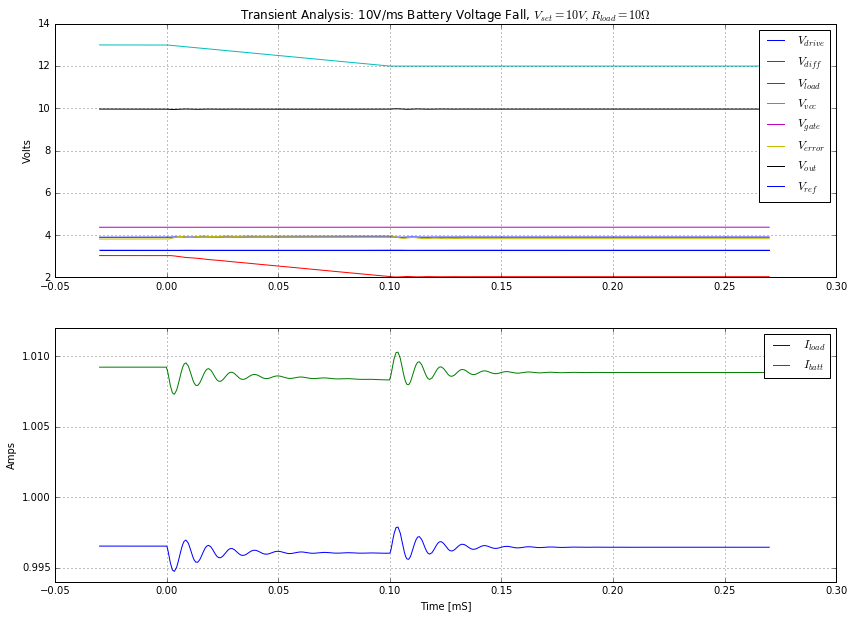

In [29]:
supplies = [
    'Vbatt VCC GND 12V  PULSE(13V 12V {pre}ms 100us)',
    'Vdis disable GND 0V']
transient_analysis(duration=0.3, supplies=supplies, action="10V/ms Battery Voltage Fall")

# Trying different MOSFETs

Requirements
* TO220 package
* max Vgs >= 20V (or we have to use a zener between gate and ground)
* Vdss breakdown > 30V
* Id > 5A (or so)
* Vgs(threshold) < 5V or so
* Rds(on) < 100mR (smaller is better)
* cheap (< $1) and available

http://www.infineon.com/cms/en/product/solutionFinder.html?channel=db3a30433cabdd35013ccebb4e4849ae&intc=0540001#!showAllParameters=false&5546d4694909da48014909dc05ad019b_false=5&5546d4694909da48014909dc0d0d0207_false=20&5546d4694909da48014909dc15af0281_false=1&sort=group&sortField=SMALLEST&5546d4694909da48014909dc081301b1_true=MAX_30.0|MAX_40.0|MAX_55.0|MAX_60.0&5546d4694909da48014909dc13370259_true=N&packageValue=TO220&statusValue=active%20and%20preferred

Candidates (there are plenty):
* IRF40B207 http://www.mouser.com/ProductDetail/Infineon-Technologies/IRF40B207
* IRFB7446 http://www.mouser.com/ProductDetail/Infineon/IRFB7446PB
* IRFB7546 http://www.mouser.com/ProductDetail/Infineon-Technologies/IRFB7546PBF
* PSMN022-30PL http://www.mouser.com/ProductDetail/Nexperia/PSMN022-30PL127
* IRLB8721 http://www.mouser.com/ProductDetail/Infineon-Technologies/IRLB8721PBF

In [30]:

node_str = "vcc load i(vbatt) i(vload)"

ksf.set_lines('supplies', [
    'Vbatt VCC GND 12V',
    'Vdis disable GND 0V'])

ksf.set_lines('control', [
    '.control',
    'dc Vbatt 11 16 0.05',
    'wrdata out1 ' + node_str,
    '.endc'])

def sweep_target_v():

    Vout = {}

    for target_v in range(6, 16):
        fix.delete_all_data_files()

        set_target(target_v)

        ksf.write_and_run('t1.cir')

        Vc, Vt, I = fix.read_wrdata_file('out1.data', node_str) 

        Vout["tar = {}V".format(target_v)] = Vt["vcc"] - Vt['load']

    title = "Load Voltage as a function of supply voltage for different set voltage, $R_{load}="+str(Rload)+"\Omega$"
    fix.plot_all(
        Vc, Vout, None,
        title=title,
        xlabel="$V_{batt}$ [Volts]")
    plt.plot(Vc, Vc, ':k')

##########STDOUT##########

Circuit: * ../hc.cir

Reducing trtol to 1 for xspice 'A' devices
Doing analysis at TEMP = 27.000000 and TNOM = 27.000000


No. of Data Rows : 101

##########STDERR##########
Note: Starting dynamic gmin stepping
Trying gmin =   1.0000E-03 Note: One successful gmin step
Trying gmin =   1.0000E-04 Note: One successful gmin step
Trying gmin =   1.0000E-05 Note: One successful gmin step
Trying gmin =   1.0000E-06 Note: One successful gmin step
Trying gmin =   3.1623E-07 Note: One successful gmin step
Trying gmin =   5.6234E-08 Note: One successful gmin step
Trying gmin =   5.6234E-09 Note: One successful gmin step
Trying gmin =   5.6234E-10 Note: One successful gmin step
Trying gmin =   5.6234E-11 Note: One successful gmin step
Trying gmin =   5.6234E-12 Note: One successful gmin step
Trying gmin =   1.0000E-12 Note: One successful gmin step
Note: Dynamic gmin stepping completed

Note: No ".plot", ".print", or ".fourier" lines; no simulations run

##########STDOU

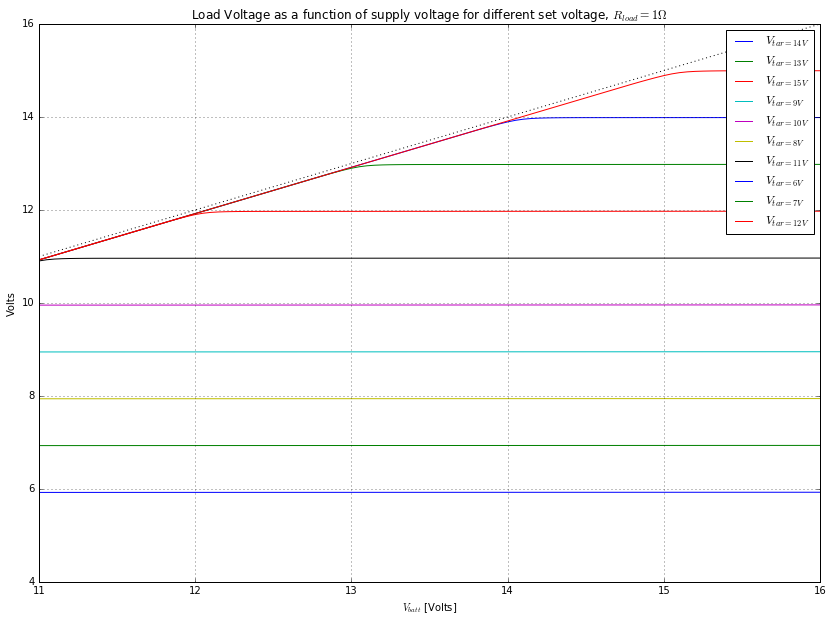

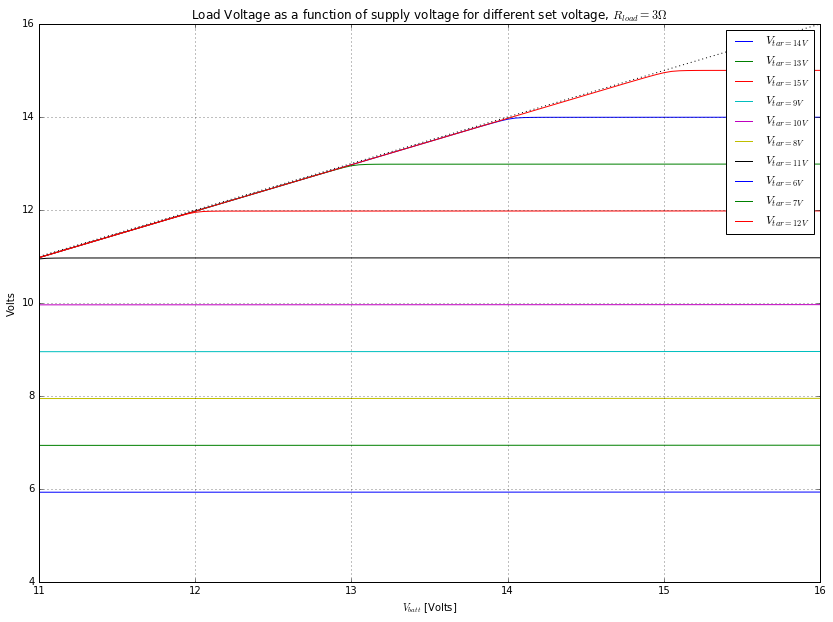

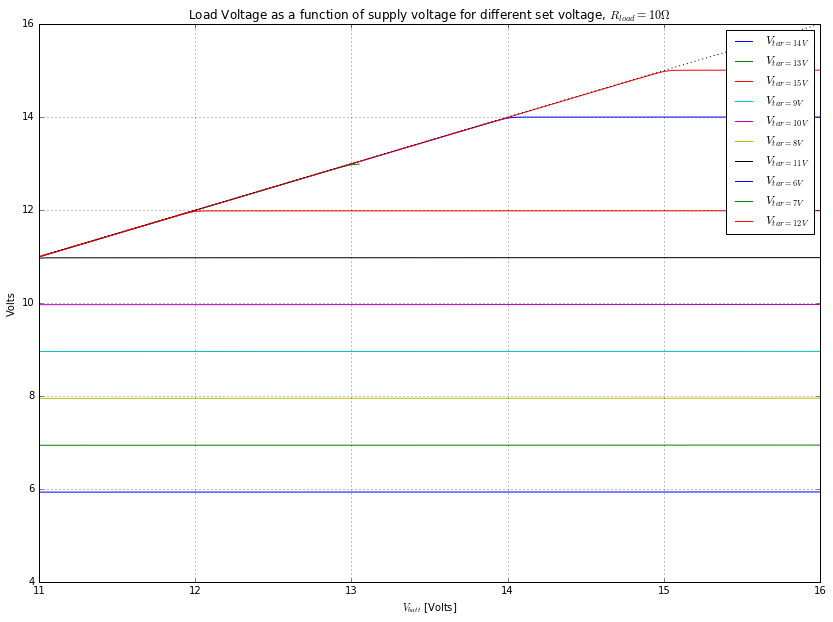

In [32]:
for r in [1, 3, 10]:
    Rload = r
    ksf.set_lines('load', [
        'Rload VCC l1 {}R'.format(Rload),
        'Lload l1 l2 4uH',
        'Vload l2 LOAD 0V',
        ])

    sweep_target_v()